In [1]:
import numpy as np
from PIL import Image

filename = "./test/rain.jpg"
pixels = np.asarray(Image.open(filename))

In [10]:
im = Image.open("./test/rain.jpg")
resized = im.resize((im.width // 2, im.height // 2))
pixels = np.asarray(resized)

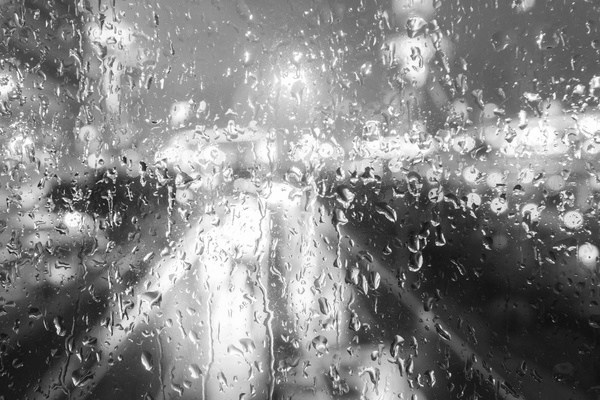

In [2]:
from instapy.python_filters import *
grayscale_image= python_color2gray(pixels)
grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)

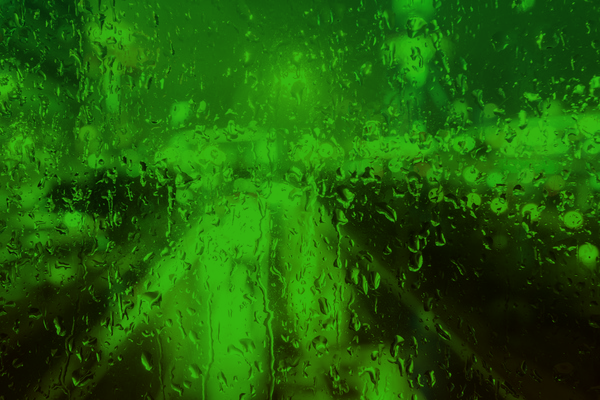

In [3]:
from instapy.numpy_filters import *
grayscale_image = numpy_color2gray(pixels)
grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)

/home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


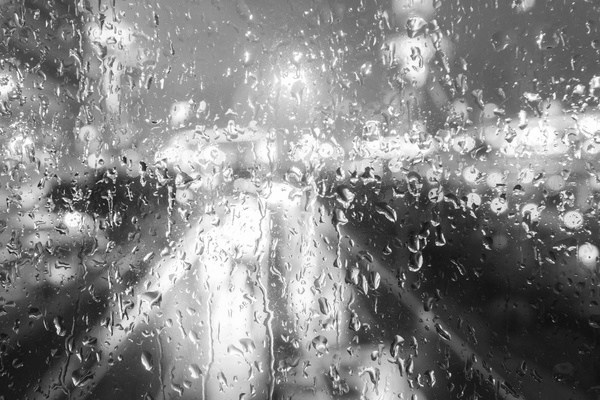

In [4]:
from instapy.numba_filters import *
grayscale_image = numba_color2gray(pixels)
grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)

In [5]:
%timeit  numba_color2gray(pixels)
%timeit  numpy_color2gray(pixels)
%timeit  python_color2gray(pixels)

26.5 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.29 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


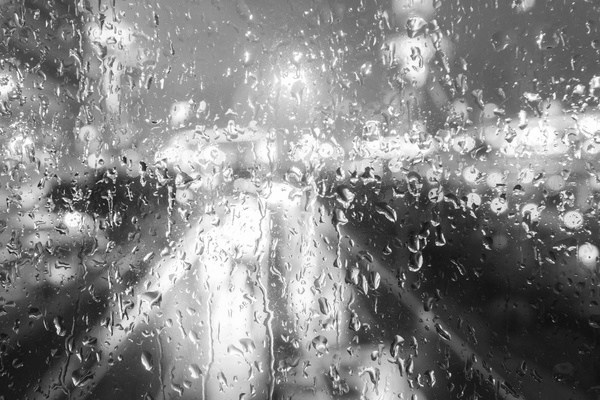

In [8]:
from instapy.cython_filters import *
grayscale_image = cython_color2gray(pixels)
grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)


In [9]:
%timeit  cython_color2gray(pixels)

5.92 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
pixels

array([[[ 63, 144, 251],
        [ 68, 142, 249],
        [ 70, 140, 254],
        ...,
        [ 66,  99, 168],
        [ 64,  99, 163],
        [ 55,  92, 144]],

       [[ 70, 147, 255],
        [ 66, 137, 251],
        [ 59, 132, 245],
        ...,
        [ 63,  91, 154],
        [ 60,  89, 155],
        [ 57,  92, 156]],

       [[ 63, 137, 244],
        [ 62, 133, 239],
        [ 54, 132, 241],
        ...,
        [ 64,  92, 155],
        [ 60,  87, 156],
        [ 62,  92, 164]],

       ...,

       [[140,  52,  12],
        [163,  63,  13],
        [173,  62,   6],
        ...,
        [ 81,  16,   0],
        [ 94,  19,   0],
        [103,  22,   3]],

       [[135,  43,   2],
        [127,  39,   1],
        [162,  62,  10],
        ...,
        [ 83,  18,   0],
        [ 96,  21,   0],
        [108,  23,   3]],

       [[126,  37,   0],
        [101,  29,   5],
        [126,  45,   2],
        ...,
        [ 83,  18,   0],
        [ 97,  20,   0],
        [109,  22,   2]]

In [11]:
res = pixels
res[:,:][:] = pixels*np.asarray([0.21,0.72,0.07])

array([[[1.3230e+01, 1.0368e+02, 1.7570e+01],
        [1.4280e+01, 1.0224e+02, 1.7430e+01],
        [1.4700e+01, 1.0080e+02, 1.7780e+01],
        ...,
        [1.3860e+01, 7.1280e+01, 1.1760e+01],
        [1.3440e+01, 7.1280e+01, 1.1410e+01],
        [1.1550e+01, 6.6240e+01, 1.0080e+01]],

       [[1.4700e+01, 1.0584e+02, 1.7850e+01],
        [1.3860e+01, 9.8640e+01, 1.7570e+01],
        [1.2390e+01, 9.5040e+01, 1.7150e+01],
        ...,
        [1.3230e+01, 6.5520e+01, 1.0780e+01],
        [1.2600e+01, 6.4080e+01, 1.0850e+01],
        [1.1970e+01, 6.6240e+01, 1.0920e+01]],

       [[1.3230e+01, 9.8640e+01, 1.7080e+01],
        [1.3020e+01, 9.5760e+01, 1.6730e+01],
        [1.1340e+01, 9.5040e+01, 1.6870e+01],
        ...,
        [1.3440e+01, 6.6240e+01, 1.0850e+01],
        [1.2600e+01, 6.2640e+01, 1.0920e+01],
        [1.3020e+01, 6.6240e+01, 1.1480e+01]],

       ...,

       [[2.9400e+01, 3.7440e+01, 8.4000e-01],
        [3.4230e+01, 4.5360e+01, 9.1000e-01],
        [3.6330e+01, 4

In [31]:
pixels[:,:,0]*0.21+pixels[:,:,1]*0.72+ pixels[:,:,2]*0.07

array([[134.48, 133.95, 133.28, ...,  96.9 ,  96.13,  87.87],
       [138.39, 130.07, 124.58, ...,  89.53,  87.53,  89.13],
       [128.95, 125.51, 123.25, ...,  90.53,  86.16,  90.74],
       ...,
       [ 67.68,  80.5 ,  81.39, ...,  28.53,  33.42,  37.68],
       [ 59.45,  54.82,  79.36, ...,  30.39,  35.28,  39.45],
       [ 53.1 ,  42.44,  59.  , ...,  30.39,  34.77,  38.87]])

In [30]:
pixels[:,:,2]*0.07

array([[17.57, 17.43, 17.78, ..., 11.76, 11.41, 10.08],
       [17.85, 17.57, 17.15, ..., 10.78, 10.85, 10.92],
       [17.08, 16.73, 16.87, ..., 10.85, 10.92, 11.48],
       ...,
       [ 0.84,  0.91,  0.42, ...,  0.  ,  0.  ,  0.21],
       [ 0.14,  0.07,  0.7 , ...,  0.  ,  0.  ,  0.21],
       [ 0.  ,  0.35,  0.14, ...,  0.  ,  0.  ,  0.14]])